In [1]:
#!/usr/bin/env python
import librosa 
from ADTLib import ADT 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import glob
import os
import numpy as np
import time
import config.nn_config as nn_config


#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}



/Users/nolanlem/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
nn_params = nn_config.get_nn_params()


'onsetsdir' : 'np-data/onsets/jack-dejohnette/'
'MIDI sequence directory' : 'plots/MIDI/jack-dejohnette/'
'sequence length' : 100
'sourcedir' : 'audio/jack-dejohnette/'
'midi dir' : 'midi/jack-dejohnette/'
'models dir' : 'models/jack-dejohnette/'
'batchsize' : 10
'ADT sequence directory' : 'plots/ADT/jack-dejohnette/'
'weightsdir' : 'model-weights/jack-dejohnette/'
'dev data dir' : 'np-data/dev-data/jack-dejohnette/'
'model type' : 'lstm'
'epochs' : 3
'rendered midi dir' : 'midi/rendered-jack-dejohnette/'
'drummer' : 'jack-dejohnette'
'training data dir' : 'np-data/training-data/jack-dejohnette/'
'slicedir' : 'audio/sliced/jack-dejohnette/'
'loss directory' : 'plots/loss/jack-dejohnette/'
'activationsdir' : 'np-data/activations/jack-dejohnette/'


In [3]:
# function to slice up source audio into snippets of 5 second length 
# and store into targetdir="./sliced-audio/" 
def sliceAudio(sourcedir, targetdir='./audio/sliced-audio/', slicedur = 5):
    if os.path.exists(targetdir) == True:
        print 'target directory is', targetdir 
    else:
        os.mkdir(targetdir)
    for audio in glob.glob(sourcedir + "/*.wav"):
        
        y, sr = librosa.load(audio, sr=44100)
        chans = y.ndim
        
        if chans > 1:
            y_in_samps = y[0].shape
        else:
            y_in_samps = len(y)
        
        total_dur = float(y_in_samps)/sr
        slice_inc = slicedur*sr # 22050*5 
        for x in range(slice_inc, y_in_samps, slice_inc):
            print x-slice_inc, x
            if chans > 1:
                audioslice = np.zeros((2, slice_inc + 1))
                audioslice[0][:] = y[0][(x - slice_inc):(x+1)]
                audioslice[1][:]= y[1][(x - slice_inc):(x+1)]
            else: 
                audioslice = y[(x - slice_inc):(x + 1)]
               
            audiofilename = targetdir + os.path.splitext(os.path.basename(audio))[0] + "_" + str(x-slice_inc+1) + "-" + str(x+1) + ".wav"
            print "slicing and writing %r" %(audiofilename)
            librosa.output.write_wav(audiofilename, audioslice, sr=sr)
        
        

In [6]:
# os.chdir("/Users/nolanlem/STANFORD/deep-learning/jazzlstm/cs230")

In [4]:
# slice up the raw audio and put into slicedir for processing later
srcdir = nn_params["sourcedir"]
slicedir = nn_params["slicedir"]
audiofname = sliceAudio(srcdir, slicedir, 5)

target directory is audio/sliced/jack-dejohnette/
0 220500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_1-220501.wav'
220500 441000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_220501-441001.wav'
441000 661500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_441001-661501.wav'
661500 882000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_661501-882001.wav'
882000 1102500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_882001-1102501.wav'
1102500 1323000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_1102501-1323001.wav'
1323000 1543500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_1323001-1543501.wav'
1543500 1764000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_1543501-1764001.wav'
1764000 1984500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_1764001-1984501.wav'
1984500 2205000
slicing and writing 'audio/sliced/j

17419500 17640000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_17419501-17640001.wav'
17640000 17860500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_17640001-17860501.wav'
17860500 18081000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_17860501-18081001.wav'
18081000 18301500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_18081001-18301501.wav'
18301500 18522000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_18301501-18522001.wav'
18522000 18742500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_18522001-18742501.wav'
18742500 18963000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_18742501-18963001.wav'
18963000 19183500
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_18963001-19183501.wav'
19183500 19404000
slicing and writing 'audio/sliced/jack-dejohnette/jack-dejohnette_19183501-19404001.wav'
19404000 19624500
slicing and writing

In [7]:

ts = time.gmtime()
modelsavefn = time.strftime("%c", ts).replace(' ', '_')

nn_params["loss directory"] + "_epochs: " + str(4) + "_" + modelsavefn + ".npy"


'plots/loss/steve-gadd/_epochs: 4_Thu_Jun__7_23:48:07_2018.npy'

In [18]:
nn_params["activationsdir"]

'np-data/activations/jack-dejohnette/'

In [9]:
# function to apply ADT processing to extract high hat, snare, and kick activation functions 
# takes a long time so, can preload saved np file if already processed

def getDrumTranscription(drumdir, sec = 5):
    druminfo = [] # list to hold drum info data
    for audio in glob.glob(drumdir + "/*.wav"):
        try:
            out = ADT([audio], save_dir=None, text='no', tab='no', output_act='no')
            druminfo.append(out)
        except (IndexError, ValueError, IOError):
            print "Couldn't analyze %r..skipping" %(audio)
       
    druminfo = np.array(druminfo)
    
    ts = time.gmtime()
    
    npsavefilename = nn_params["activationsdir"] + nn_params["drummer"] + ".npy"

    print 'saving file as %r' %(npsavefilename)
    np.save(npsavefilename, druminfo) # save the drum data to data dir 
    return druminfo

In [6]:
def quantize(notesarray, targetlen, keepAmplitudes=True):
    # function to quantize sequences to desired length 
    # keepAmplitudes = True # retain original amplitudes 
    len_source = notesarray.shape[0] # 
    posarr = np.nonzero(notesarray)
    #print 'source array shape', notesarray.shape
    #print 'want to quantize to %r length' %(targetlen)
    
    tvect = np.zeros(targetlen) # vector to hold target notes array
    bins = np.linspace(0, len_source - 1, targetlen)
    
    idx = np.digitize(posarr, bins)
    if keepAmplitudes:
        tvect[idx-1] = notesarray[posarr]
    else:
        tvect[idx-1] = 1 
    return tvect

In [83]:
# [out, act] = ADT(['audio/audio-funk/funk.wav'], output_act = 'yes')
n_

INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/HihatADTLibAll


In [21]:
slicedir = nn_params['slicedir']
print slicedir

audio/sliced/jack-dejohnette/


In [10]:
# run the drumTranscription function to return all the beat activations per instrument 
# if np activation file already exists then load that instead 
#drumactivations = np.load(nn_params["activationsdir"] + "steve-gadd-activations.npy")# have to find the exact file name bc it was timestamped

drumactivations = getDrumTranscription(slicedir)

INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/HihatADTLibAll
Couldn't analyze 'audio/sliced/jack-dejohnette/jackyboy_1764001-1984501.wav'..skipping
INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /Users/nolanlem/anaconda2/lib/python2.7/site-packages/ADTLib/files/HihatADTLibAll
Couldn't analyze 'audio/sliced/jack-dejohnette/jack-dejohnette_7717501-7938001.wav'..skipping


KeyboardInterrupt: 

In [24]:
def stackDrumData(drumdata, seconds = 5, quant = 24):
    bins = np.linspace(0, seconds, seconds*quant) # 5 second quantized into 8 time units per second (5*8) + 1
    # empty np arrays
    kickvect = np.zeros(len(bins))
    snvect = np.zeros(len(bins))
    hhvect = np.zeros(len(bins))

    hh = np.empty((0, len(bins)))
    kick = np.empty((0, len(bins)))
    sn = np.empty((0, len(bins)))

    # for hihat
    for data in drumdata:
        # empty np array        
        if data.ndim == 1:
            hihatdata = data[0]["Hihat"]
            hhindexes = np.digitize(hihatdata, bins) 
            hhvect[hhindexes - 1] = 1

            kickdata = data[0]["Kick"]
            kickindexes = np.digitize(kickdata, bins) 
            kickvect[kickindexes - 1] = 1

            snaredata = data[0]["Snare"]
            snindexes = np.digitize(snaredata, bins) 
            snvect[snindexes-1] = 1  
        else:
            hihatdata = data["Hihat"]
            hhindexes = np.digitize(hihatdata, bins) 
            hhvect[hhindexes - 1] = 1

            kickdata = data["Kick"]
            if not kickdata:
                kickdata = np.array([0])
            kickindexes = np.digitize(kickdata, bins) 
            kickvect[kickindexes - 1] = 1

            snaredata = data["Snare"]
            snindexes = np.digitize(snaredata, bins) 
            snvect[snindexes-1] = 1
            
        
        hh = np.vstack((hh, hhvect))
        kick = np.vstack((kick, kickvect))
        sn = np.vstack((sn, snvect))

    return hh, kick, sn

#         kick.append(kickdata)
#         sn.append(snaredata)
        #print hihatdata
#     hhindexes = np.digitize(hh, bins)
#     kickindexes = np.digitize(kick, bins)
#     snindexes = np.digitize(sn, bins)
    
    

In [25]:
# dim_1 of output shape will be seconds*quant 
seconds = 5 
quant=8
vectorsize = seconds*quant

hh, kick, sn = stackDrumData(drumactivations, seconds=seconds, quant=quant) #24 is 8th note triplet 

In [26]:
hh.shape

(96, 40)

In [27]:
# get all the spectral onsets 
# get estimated bpm per FRAME --> dtempo
def constructbeats(tempovect):
    hop_length = 512.0 
    sr = 44100.0    
    total_num_frames = len(tempovect) # just over 1 second of frames
    frames_in_sec = sr/hop_length
    print 'size of beatframes', tempovect.shape
    tempovectinframes = tempovect/(60.0*frames_in_sec)
    beat = 0 
    beats = []   
    for i in range(len(tempovectinframes)):
        beat += tempovectinframes[i] # accumulate beatframe until reaching 1
        if beat >= 1.0:
            beats.append(i*hop_length)
            #print 'for bpm %r, create a beat at sample number %r' %(tempovect[i],hop_length*i)
            beat = 0        
    # return the sample numbers to place beat on top of
    return beats

frames = 431 # quant*seconds

def getallonsets(audiopath,binflag=False, thresh=0.0, d=10.0):
    onsetsarray = np.empty((0,frames)) 
    print '---the audio path: %r---'%(audiopath)
    
    for audio in glob.glob(audiopath+"/*.wav"):
        [y,sr] = librosa.load(audio, duration=d, sr=44100)
        print '...loading audio %r sr: %r, samples: %r...'%(audio, sr, len(y))
        onset_env = librosa.onset.onset_strength(y, sr) # extract onset envelope per frame
        print 'onset_env shape', onset_env.shape
        onset_env /= max(onset_env) # normalize
        onset_env = np.around(onset_env,decimals=1) # squash into 0.1,0.2,0.3 increments
        if binflag==True:
            onset_env[onset_env<thresh]=0
            onset_env[onset_env>=thresh]=1
        
        # local tempo estimates
        tempframebuff = np.copy(onset_env)


        dtempo = librosa.beat.tempo(onset_envelope=onset_env,
                               aggregate=None)

        dtsamps = constructbeats(dtempo) # beat onsets to sample pos
        dtframes = librosa.samples_to_frames(dtsamps) # sample pos back to frame
        for frame in dtframes:
            tempframebuff[frame] = 1.0

        tempframebuff = np.reshape(tempframebuff,(1,len(tempframebuff)))

        #print tempframebuff   
        #tempframebuff = quantize(tempframebuff, frames, keepAmplitudes=True)
        #print(onsetsarray.shape, tempframebuff.shape)

        
        onsetsarray = np.vstack((onsetsarray, tempframebuff))
    np.save(nn_params["onsetsdir"] + "onsets" + ".npy", onsetsarray)    
    return onsetsarray[:] # return all audio except empty vector at [0]

In [19]:
nn_params["drummer"]

'steve-gadd'

In [20]:
onsetsarray.shape

NameError: name 'onsetsarray' is not defined

In [28]:
# now get all the Global Tempo Estimates and Spectral Onset Information 
onsetsarray = getallonsets(nn_params["slicedir"])


---the audio path: 'audio/sliced/jack-dejohnette/'---
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_7717501-7938001.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_6174001-6394501.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_9481501-9702001.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_13009501-13230001.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_16537501-16758001.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_6394501-6615001.wav' sr: 44100, samples: 220501...
onset_env sha

size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_9040501-9261001.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_4851001-5071501.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_13671001-13891501.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_7497001-7717501.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_8158501-8379001.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (431,)
...loading audio 'audio/sliced/jack-dejohnette/jack-dejohnette_882001-1102501.wav' sr: 44100, samples: 220501...
onset_env shape (431,)
size of beatframes (4

In [29]:
def quantizeMatrix(beatsmatrix, targetlen, keepAmplitudes=True):
    onsetsquant = np.empty((0, targetlen))

    for seq in beatsmatrix:
        a = quantize(seq, vectorsize, keepAmplitudes=keepAmplitudes)
        onsetsquant = np.vstack((onsetsquant, a))
    return onsetsquant

In [30]:
# apply the quantization to the onsets arrays so that they will be same size as ADT data
beatsarray = quantizeMatrix(onsetsarray, vectorsize, keepAmplitudes=True) 

In [4]:
nn_params

{'ADT sequence directory': 'plots/ADT/metallica/',
 'MIDI sequence directory': 'plots/MIDI/metallica/',
 'activationsdir': 'np-data/activations/metallica/',
 'batchsize': 10,
 'dev data dir': 'np-data/dev-data/metallica/',
 'drummer': 'metallica',
 'epochs': 3,
 'loss directory': 'plots/loss/metallica/',
 'midi dir': 'midi/metallica/',
 'model type': 'stateful-lstm-time-distributed',
 'models dir': 'models/metallica/',
 'onsetsdir': 'np-data/onsets/metallica/',
 'rendered midi dir': 'midi/rendered-metallica/',
 'sequence length': 100,
 'slicedir': 'audio/sliced/metallica/',
 'sourcedir': 'audio/metallica/',
 'training data dir': 'np-data/training-data/metallica/',
 'weightsdir': 'model-weights/metallica/'}

In [70]:
for i in range(10):
    print hh[i,:]

[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
[1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.]
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.]
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 

In [60]:
plt.close()

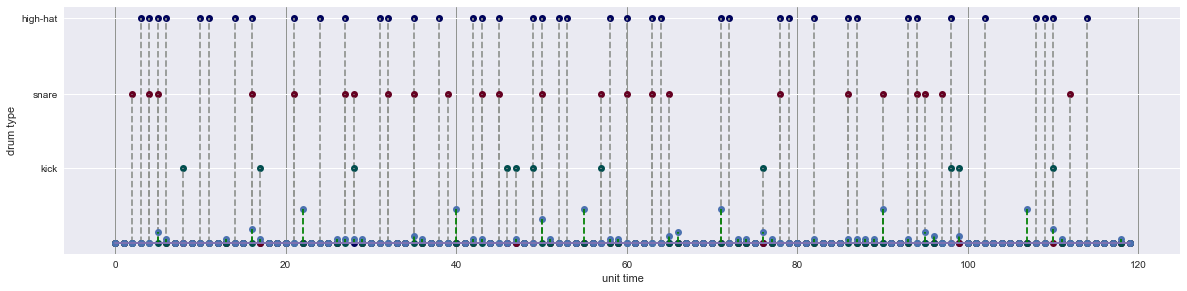

In [63]:
hihat = hh
kickdrum = kick
snare = sn
beatsarray = beatsarray*0.9
numtoplot=8 
savefigs=False

sample = 3

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)


hhmkline, hhstemlines, hhbaseline = plt.stem(hihat[sample-1], linefmt='--')
snmkline, snstemlines, snbaseline = plt.stem(snare[sample-1]*0.66,linefmt='--')
kmkline, kstemlines, kbaseline = plt.stem(kickdrum[sample-1]*0.33,linefmt='--')

plt.setp(hhmkline, color='xkcd:dark blue')
plt.setp(hhstemlines, color='xkcd:grey')
plt.setp(snmkline, color='xkcd:maroon')
plt.setp(snstemlines, color='xkcd:grey')
plt.setp(kmkline, color='xkcd:dark teal')
plt.setp(kstemlines, color='xkcd:grey')      

plt.ylabel("drum type")
plt.xlabel("unit time")
ax1 = plt.gca()
ax1.set_yticks((0.33, 0.66, 1.0))
ax1.set_yticklabels((r'kick', r'snare', r'high-hat'))
ax1.grid(color="xkcd:grey", axis='x', linestyle='-')

plt.stem(beatsarray[sample-1], '--g')       
#ax.set_title("unit time")
#ax = plt.gca()
#ax.set_yticks((0.33, 0.66, 1.0))
#ax.set_yticklabels((r'pulse activation'))

#savefilename = nn_params["ADT sequence directory"] + "comb" + str(sample) + ".png"

plt.savefig(savefilename, dpi=100)


In [32]:
# function to plot both the ADT sequences and the global tempo estimate + spectral onset information 
def plotAllDrumSequences(hihat, kickdrum, snare, beatsarray, numtoplot=8, savefigs=False):
    num_samps = hh.shape[1]
    #fig, ax = plt.subplots(num_samps, 1)
    for sample in range(1, numtoplot*2, 1):
        fig = plt.figure(figsize=(20,10))


        ax1 = fig.add_subplot(sample, 1,1)
        hhmkline, hhstemlines, hhbaseline = plt.stem(hihat[sample-1], linefmt='--')
        snmkline, snstemlines, snbaseline = plt.stem(snare[sample-1]*0.66,linefmt='--')
        kmkline, kstemlines, kbaseline = plt.stem(kickdrum[sample-1]*0.33,linefmt='--')
        
        plt.setp(hhmkline, color='xkcd:dark blue')
        plt.setp(hhstemlines, color='xkcd:grey')
        plt.setp(snmkline, color='xkcd:maroon')
        plt.setp(snstemlines, color='xkcd:grey')
        plt.setp(kmkline, color='xkcd:dark teal')
        plt.setp(kstemlines, color='xkcd:grey')      
        
        plt.ylabel("drum type")
        plt.xlabel("unit time")
        ax1.set_yticks((0.33, 0.66, 1.0))
        ax1.set_yticklabels((r'kick', r'snare', r'high-hat'))
        ax1.grid(color="xkcd:grey", axis='x', linestyle='-')
        
        #####
        ax2 = fig.add_subplot(sample+1,1,2)
        
    
        plt.stem(beatsarray[sample-1], '--g')       
        ax2.set_ylabel("pulse activation amplitude")
        #ax.set_title("unit time")
        #ax = plt.gca()
        #ax.set_yticks((0.33, 0.66, 1.0))
        #ax.set_yticklabels((r'pulse activation'))
        ax2.grid(color='xkcd:grey', axis='x', linestyle='-')
        
        savefilename = nn_params["ADT sequence directory"] + str(sample) + ".png"

        plt.savefig(savefilename, dpi=60)
        fig.close()

            
    plt.show()
    
        

AttributeError: 'Figure' object has no attribute 'close'

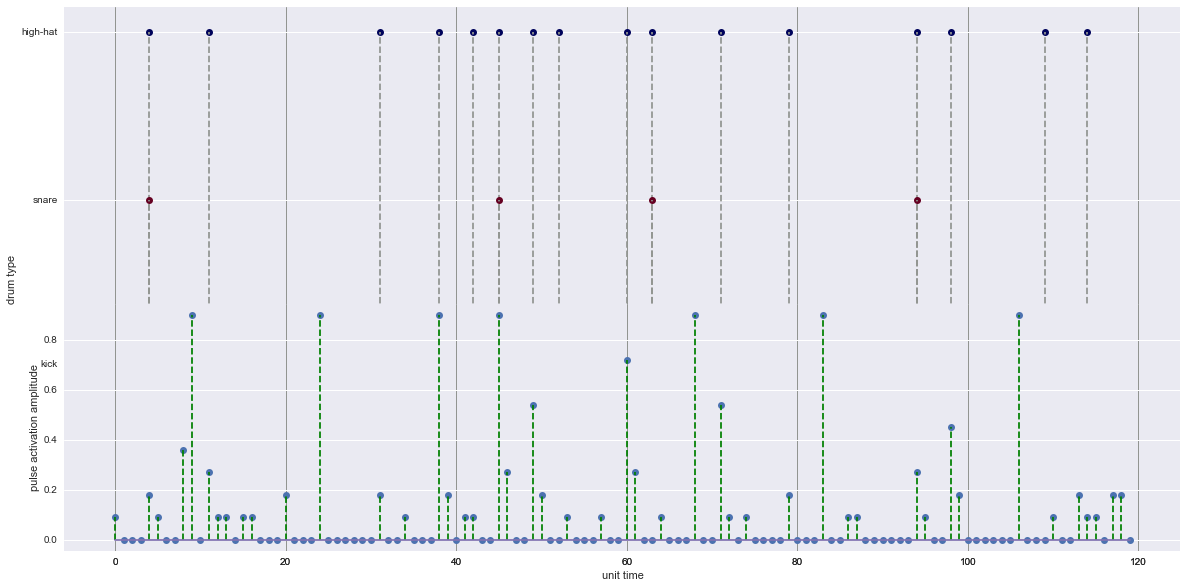

In [33]:
# run the plotter to check the activation content
mpl.style.use('seaborn')
plotAllDrumSequences(hh, kick, sn, beatsarray*0.9, numtoplot=8)

In [31]:
# function to merge ADT sequences with Beat Onset sequences
def mergeSequencesWithBeats(hh, sn, k, beatsarray):
    seqstack = np.empty((0, 120, 4))
    for hhseq, snseq, kseq, barr in zip(hh, sn, k, beatsarray):
        tmpstack = np.vstack((hhseq, snseq, kseq, barr))
        #print tmpstack.shape
        tmpstack = np.reshape(tmpstack.T, (1, tmpstack.shape[1], tmpstack.shape[0]))
        #print tmpstack.shape
        seqstack = np.vstack((seqstack, tmpstack))
    return seqstack 
    

In [37]:
print nn_params

{'onsetsdir': 'np-data/steve-gadd-onsets/', 'epochs': 50, 'weightsdir': 'model-weights/steve-gadd-weights/', 'sourcedir': 'audio/steve-gadd/', 'activationsdir': 'np-data/steve-gadd-activations/', 'ADT sequence directory': 'plots/ADT/steve-gadd/', 'MIDI sequence directory': 'plots/MIDI/steve-gadd/', 'rendered midi dir': 'midi/rendered-steve-gadd/', 'drummer': 'steve-gadd', 'training data dir': 'np-data/training-data/steve-gadd/', 'slicedir': 'audio/sliced-steve-gadd/', 'nn_architecture': 'lstm'}


In [39]:
# run function to merge the Sequences with the Beats
seqstack = mergeSequencesWithBeats(hh,sn,kick,beatsarray)

In [43]:
# applied after merge sequences with beats... function to create X_train and Y_train tensors 
def sliceSeqStack(midimat, seqlen=20):
    print 'midimat shape:', midimat.shape
    X = np.empty((0, seqlen - 1, midimat.shape[2]))    
    Y = np.empty((0, midimat.shape[2]))
    total_len = midimat.shape[1] # ()
    print 'total len:', total_len
    
    for sample in midimat: # for sample (dim=0) in matrix 
        for i in range(seqlen, total_len, 1):
            #print (i - seqlen), i
            sampleslice = sample[(i - seqlen): i, :]
            #print 'midislice.shape', sampleslice.shape
            x_t = sampleslice[0:-1, :] # the training time steps with last time step sliced off
            y_t = x_t[-1, :] 
            #print 'x_t shape:', x_t.shape
            #print 'y_t shape:', y_t.shape
            # reshape arrays to prepare to stack
            x_t = np.reshape(x_t, (1, x_t.shape[0], x_t.shape[1]))
            y_t = np.reshape(y_t, (1, y_t.shape[0]))
            # vertical stack onto x_tr and y_tr mats
            X = np.vstack((X, x_t))
            Y = np.vstack((Y, y_t))
    
    return X, Y

In [40]:
nn_params["training data dir"] + nn_params["drummer"] + "_X.npy"

'np-data/training-data/steve-gadd/steve-gadd_X.npy'

In [44]:
# run the function to slice up the Final Sequence Matrix to get X_train and Y_train tensors
X_seqs, Y_seqs = sliceSeqStack(seqstack, seqlen=20) # 20 steps 
# split into training and development sets at some split,
X_train, Y_train, X_dev, Y_dev = splitData(X_seqs, Y_seqs, split=0.9)

midimat shape: (84, 120, 4)
total len: 120


In [571]:
# HOW TO SPLIT UP INPUT DATA FOR TRAINING and DEV?
# can load directy
# X_seqs = np.load(nn_params["training data dir"] + nn_params["drummer"] + "_X.npy")
# Y_seqs = np.load(nn_params["training data dir"] + nn_params["drummer"] + "_Y.npy")
def splitData(X, Y, split=0.9):
    training_set_split = split 
    dev_set_prop = 1 - training_set_split

    trainamt = int(np.round(X.shape[0]*training_set_split))
    X_train = X[:trainamt, :, :]
    Y_train = Y[:trainamt, :]

    X_dev = X_seqs[trainamt:, :, :]
    Y_dev = Y_seqs[trainamt:, :]

    # sanity check
    print 'Training on %r percent of data and developing on %r percent' %(training_set_split*100, dev_set_prop*100)
    print 'X_train.shape:', X_train.shape
    print 'Y_train.shape:', Y_train.shape
    print '\nX_dev.shape:', X_dev.shape
    print 'Y_dev.shape:', Y_dev.shape
    
    return X_train, Y_train, X_dev, Y_dev



Training on 90.0 percent of data and developing on 9.999999999999998 percent
X_train.shape: (7560, 19, 4)
Y_train.shape: (7560, 4)

X_dev.shape: (840, 19, 4)
Y_dev.shape: (840, 4)


In [98]:
# sanity check 
print "hh shape", hh.shape 
print "kick shape", kick.shape
print "snare shape", sn.shape

hh shape (3, 41)
kick shape (3, 41)
snare shape (3, 41)


In [106]:
def sliceInstruments(hh, kick, sn):
    timeslices = np.empty((3, len(hh[0])))
    for h, k, sn in zip(hh, kick, sn):
        timeslice = [np.array(a) for a in zip(h, k, sn)]
        timeslice = np.array(timeslice)
        timeslice = timeslice.T
        #print timeslice.shape
        #print timeslice
        #timeslices = np.hstack((timeslices, timeslice)) # --> (3, 648)
        timeslices = np.dstack((timeslices, timeslice))


    return timeslices

In [107]:
instrumentslices = sliceInstruments(hh,kick,sn)

(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)
(3, 41)


In [108]:
instrumentslices.T.shape

(50, 41, 3)

In [ ]:
ins = np.reshape(instrumentslices, (instrumentslices.shape[2])

In [ ]:
snaretimes = out[0]["Snare"]
print "snare activation times are", snaretimes
# construct time vector for quantization
bins = np.linspace(0,11,41)
print bins
# quantize the snare event times 
inds = np.digitize(snaretimes, bins)
print inds
tvect = np.zeros((1,len(bins)))

# construct event vector
for idx in inds:
    tvect[0][idx] = 1

print tvect

In [ ]:
# function to plot instruments per sample 
def plotInstruments(drumdata):
    hhvect = np.array(drumdata[0]["Hihat"])
    kickvect = np.array(drumdata[0]["Kick"])
    snvect = np.array(drumdata[0]["Snare"])
    maxelem = max(len(hhvect), len(kickvect), len(snvect)) # get list with most events
    print maxelem
    
    if len(hhvect) != maxelem: 
        hhvect = np.pad(hhvect, (0, maxelem - len(hhvect)), 'constant', constant_values = (0,0))
    if len(kickvect) != maxelem: 
        kickvect = np.pad(kickvect, (0, maxelem - len(kickvect)), 'constant', constant_values = (0,0))
    if len(snvect) != maxelem:
        snvect = np.pad(snvect, (0, maxelem - len(snvect)),'constant', constant_values = (0,0))
    
    print hhvect.shape, kickvect.shape, snvect.shape
    
    # expand dims 
    hhvect = np.expand_dims(hhvect, axis=0)
    kickvect = np.expand_dims(kickvect, axis=0)
    snvect = np.expand_dims(snvect, axis=0)

    
    tvect = np.ones((1, maxelem))
    plt.figure()
    ax = plt.gca()
    hhmarkerline, hhstemlines, hhbaseline = plt.stem(hhvect[0], tvect[0], 'b--')
    kickmarkerline, kickstemlines, kickbaseline = plt.stem(kickvect[0], tvect[0]*0.66, 'r--')
    snmarkerline, snstemlines, snbaseline = plt.stem(snvect[0], tvect[0]*0.33, 'g--')
    plt.setp(hhstemlines, 'linewidth', 1)
    plt.show()
    

In [ ]:
plotInstruments(out)

In [ ]:
plt.figure()
hhvect = out[0]["Hihat"]
hhvect = np.array([hhvect])
tvect = np.ones((1,len(hhvect[0])))
print tvect.shape
print hhvect.shape
plt.stem(hhvect[0], tvect[0])
plt.show()


In [ ]:
drinfo = getDrumTranscription("testaudio")

In [392]:
def sliceBeatData(beatmat, seqlen=20):
    print 'midimat shape:', beatmat.shape
    X = np.empty((0,seqlen-1))
    Y = []
    total_len = beatmat.shape[1] # num of timesteps
    print 'total len:', total_len
    for row in beatmat:
        for i in range(seqlen, total_len, 1):
            print (i-seqlen), i
            beatslice = row[(i - seqlen): i]
            print 'beatslice.shape', beatslice.shape
            x_t = beatslice[:-1] # the training time steps with last time step sliced off
            y_t = x_t[-1] 
            print 'x_t shape:', x_t.shape
            print 'y_t shape:', y_t.shape
            # reshape arrays to prepare to stack
            x_t = np.reshape(x_t, (1, x_t.shape[0]))
            # vertical stack onto x_tr and y_tr mats
            X = np.vstack((X, x_t))
            Y.append(y_t)

    return X, np.array(Y) # should be X.dim = (num_samples, seq_len-1) Y.dim = (num_samples,)

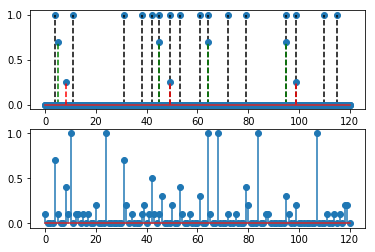

In [199]:
a = quantize(onsetsarray[0], 121, keepAmplitudes=True)
plt.figure()
plt.subplot(2,1,1)
plt.stem(hh[0], '--k')
plt.stem(sn[0]*0.7, '--g')
plt.stem(kick[0]*0.25, '--r')
plt.subplot(2,1,2)
plt.stem(a)
plt.show()

In [393]:
X, Y = sliceBeatData(beatsarray)

midimat shape: (84, 120)
total len: 120
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
16 36
beatslice.shape (20,

x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
66 86
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
67 87
beatslice.shape (20

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
16 36
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
17 37
beatsl

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
66 86
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
67 

0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
16 36
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
17 37
b

50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
66 86
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: 

y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
16 36
beatslice.shape (20,)
x_t shape: (19,)
y_t sha

y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
66 86
beatslice.shape (20,)
x_t shape: (19

x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
16 36
beatslice.shape (20,)
x_t sha

x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
66 86
beatslice.shape (20

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
16 36
beatsli

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
66 

99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
16 36


49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: 

y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t shape: (19,)
y_t sh

y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20,)
x_t shape: (19

x_t shape: (19,)
y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatslice.shape (20,)
x_t sh

x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 85
beatslice.shape (20

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35
beatsl

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
65 

98 118
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
15 35

48 68
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: 

y_t shape: ()
98 118
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t shape: (19,)
y_t s

y_t shape: ()
48 68
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20,)
x_t shape: (19

x_t shape: (19,)
y_t shape: ()
98 118
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beatslice.shape (20,)
x_t s

x_t shape: (19,)
y_t shape: ()
48 68
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 84
beatslice.shape (20

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
98 118
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 34
beats

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
48 68
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
64 

97 117
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
98 118
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
14 3

47 67
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
48 68
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: 

y_t shape: ()
97 117
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
98 118
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
99 119
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
0 20
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
1 21
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
2 22
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
3 23
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
4 24
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
5 25
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
6 26
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
7 27
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
8 28
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
9 29
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
10 30
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
11 31
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
12 32
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
13 33
beatslice.shape (20,)
x_t shape: (19,)
y_t 

y_t shape: ()
47 67
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
48 68
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
51 71
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
52 72
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
53 73
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
54 74
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
55 75
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
56 76
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
57 77
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
58 78
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
59 79
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
60 80
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
61 81
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
62 82
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
63 83
beatslice.shape (20,)
x_t shape: (19

34 54
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
35 55
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
36 56
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
37 57
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
38 58
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
39 59
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
40 60
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
41 61
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
42 62
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
43 63
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
44 64
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
45 65
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
46 66
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
47 67
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
48 68
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
49 69
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
50 70
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: 

x_t shape: (19,)
y_t shape: ()
22 42
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
23 43
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
24 44
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
25 45
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
26 46
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
27 47
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
28 48
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
29 49
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
30 50
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
31 51
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
32 52
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
33 53
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
34 54
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
35 55
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
36 56
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
37 57
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
38 58
beatslice.shape (20

beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
72 92
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
73 93
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
74 94
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
75 95
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
76 96
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
77 97
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
78 98
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
79 99
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
80 100
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
81 101
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
82 102
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
83 103
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
84 104
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
85 105
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
86 106
beatslice.shape (20,)
x_t shape: (19,)
y_t shape: ()
87 107
beatslice.shape (20,)
x_t shape: (19,)
y_t shape